In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [2]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [3]:
from turtle import setposition


def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p,od_sp=None, mRNA_fun=None):

    # Parameters
    kdegR, ktrans_Rep, ktrans_Amp, ktrans_PDC_Amp, ktrans_PDC_invert, kdegP_Rep, kdegP_Amp, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    x_guess = x

    if mRNA_fun is None:
        global setpoint
        mRNA_setpoint = setpoint[1]
    else:
        mRNA_setpoint = mRNA_fun(t)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # mRNA_blind = 1

    

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    dmRNA_invert_dt = (mRNA_setpoint - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNA_setpoint - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans_Rep  # * ((mu_max_invert + kdegP_Rep) / ktrans_Rep)
    ktrans_scaled_PDC_invert = ktrans_PDC_invert  #* ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans_Amp  # * ((mu_max_amp + kdegP_Amp) / ktrans_Amp)
    ktrans_scaled_PDC_amp = ktrans_PDC_Amp  #* ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp
    
    # if setpoint[1] > 0.5:
    #     print(d)
    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [4]:
kdegR = 0.042116
ktrans_PDC = 1.4514
ktrans_Rep = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [5]:
u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

In [7]:
from tqdm import tqdm
from scipy.interpolate import interp1d

recalc = False

if recalc:
    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr = np.zeros(u_arr.size)

    setpoint = None
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
        # print(setpoint)
        mRNAss = setpoint[1]
        mRNA_arr[i] = mRNAss

u_to_mRNA_fun = interp1d(u_arr, mRNA_arr, kind='cubic', fill_value='extrapolate')

100%|██████████| 101/101 [03:42<00:00,  2.21s/it]


In [23]:
K_Rep = 0.05
n_Rep = 3
mu_max_invert = 0.49 / 60

K_Amp = 0.05
mu_max_amp = 0.49 / 60
n_Amp = 3

kdegP_Amp = 0.003
kdegP_Rep = 0.004

kdegR = 0.042116

ktrans_PDC = 1.4514 / 1
ktrans_Rep = 1.4514 / 7
ktrans_Amp = 1.4514 / 7

ktrans_Rep = ktrans_Rep  * ((mu_max_invert + kdegP_Rep) / ktrans_Rep)  / 1
ktrans_Amp = ktrans_Amp  * ((mu_max_amp + kdegP_Amp) / ktrans_Amp) / 2


kdegPPDC = 0.00
Ks = 20

ktrans_scaled_PDC_invert = ktrans_PDC  * ((mu_max_invert + kdegPPDC) / ktrans_PDC)
ktrans_scaled_PDC_amp = ktrans_PDC  * ((mu_max_amp + kdegPPDC) / (ktrans_PDC))


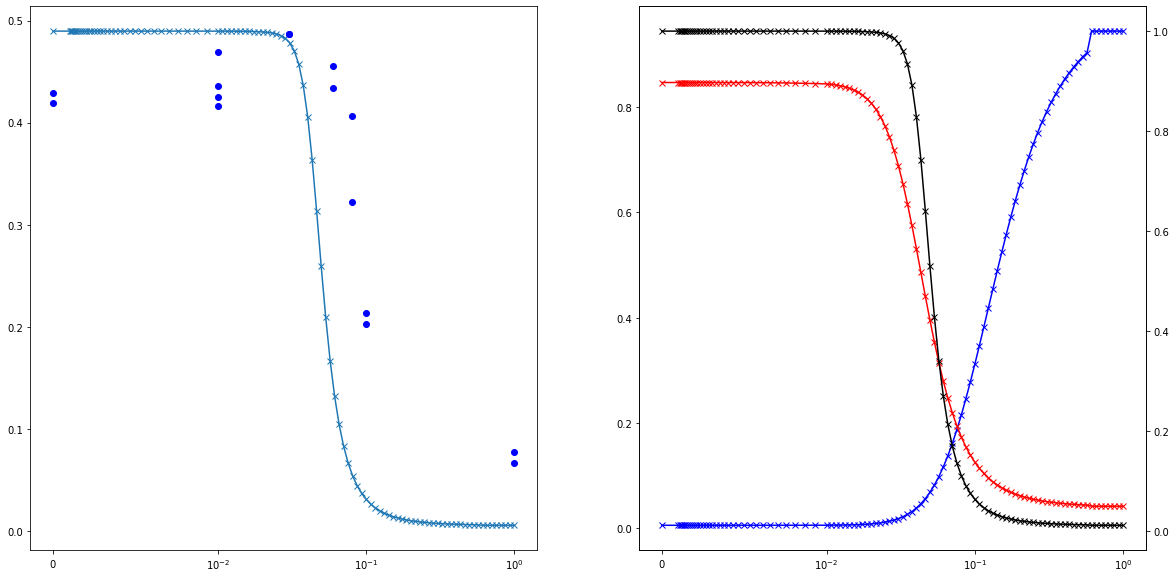

In [24]:
# Inverted Circuit


import matplotlib.pyplot as plt

ss_Rep = - (1 / (2 * mu_max_invert)) * (kdegP_Rep - np.sqrt(4 * mRNA_arr * mu_max_invert * ktrans_Rep + kdegP_Rep ** 2))
ss_Rep_max = - (1 / (2 * mu_max_invert)) * (kdegP_Rep - np.sqrt(4 * 1 * mu_max_invert * ktrans_Rep + kdegP_Rep ** 2))

ktrans_scaled_PDC_invert = ktrans_PDC  * ((mu_max_invert + kdegPPDC) / (ktrans_PDC))

# ss_Rep = mRNA_arr
# ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
# dEnz_invert_dt = ktrans_scaled_invert * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_x_invert) * Enz_invert
ss_Enz = - (1 / (2 * mu_max_invert)) * (kdegPPDC - np.sqrt(4 * (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)) \
    * mu_max_invert * ktrans_scaled_PDC_invert + kdegPPDC ** 2))

S = 20 - 2 * Y

mu_arr_invert = ss_Enz * mu_max_invert * 60 # * S / (Ks + S) 

# Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10), facecolor='white')
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_invert, '-x', label='mu')
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-bx', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (K_Rep / (K_Rep + ss_Rep)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


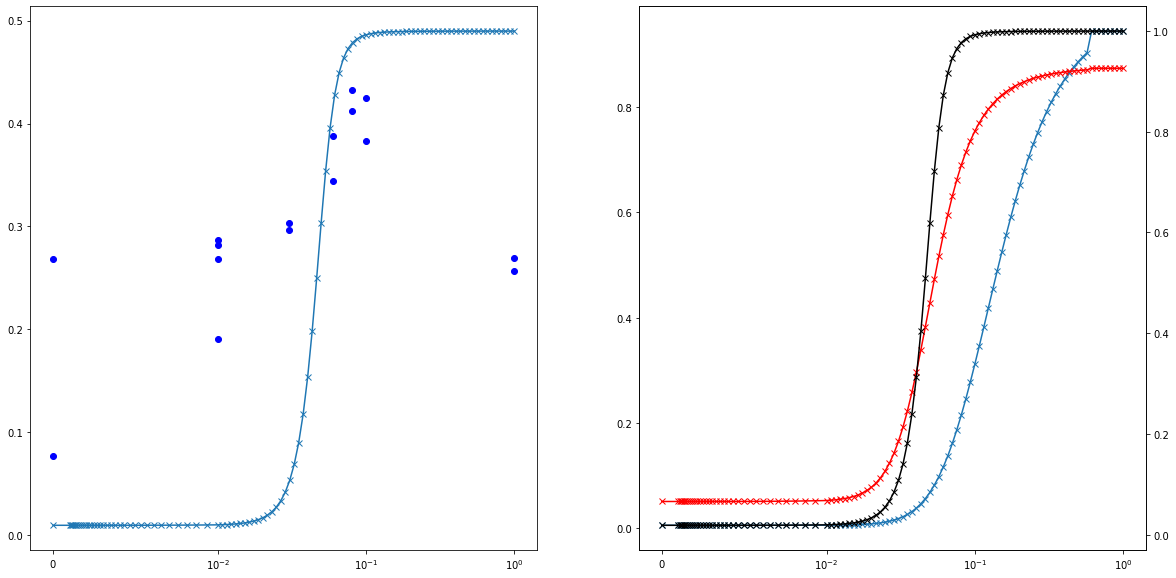

In [25]:
# Amp Circuit

import matplotlib.pyplot as plt

ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP_Amp - np.sqrt(4 * (mRNA_arr * mu_max_amp * ktrans_Amp) + kdegP_Amp ** 2))
ss_Amp_max = - (1 / (2 * mu_max_amp)) * (kdegP_Amp - np.sqrt(4 * (1 * mu_max_amp * ktrans_Amp) + kdegP_Amp ** 2))

# ktrans_scaled_PDC_amp = ktrans_PDC  #* ((mu_max_amp + kdegPPDC) / (ktrans_PDC * (ss_Amp_max ** n_Amp / (K_Amp ** n_Amp + ss_Amp_max ** n_Amp))))
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled_PDC_amp + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp *60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10), facecolor='white')
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


[0.04977024] [0.04641589]
[0.30326109] [0.24931257]
[0.26016412] [0.31330835]


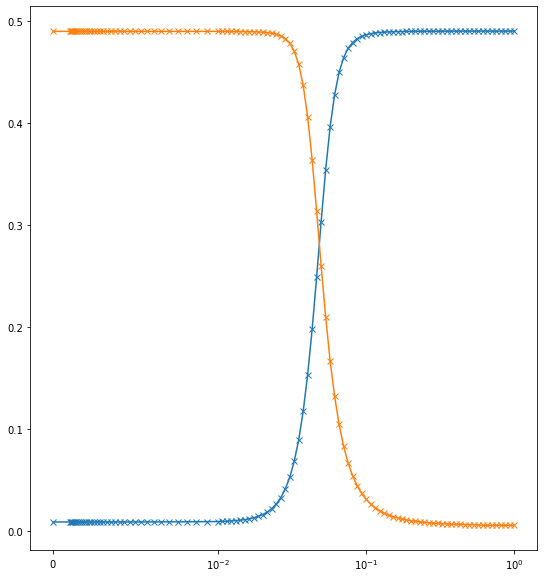

In [26]:
fig = plt.figure(figsize=(20,10), facecolor='white')
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
ax.set_xscale('symlog', linthresh=0.01)

idx = np.argwhere(np.diff(np.sign(mu_arr_amp - mu_arr_invert))).flatten()
print(u_arr[idx],u_arr[idx+1])
print(mu_arr_amp[idx], mu_arr_amp[idx+1])
print(mu_arr_invert[idx], mu_arr_invert[idx+1])

In [73]:
u_sine_period = 10 * 1 # min
u_sine_amp = 0.0
u_sine_offset = 0.071897
u_sine_n = 1.0
favor_amp = False
# u_sine_offset = 0.114

In [74]:
x_init

array([ 0.07416222,  0.07416222,  0.06732167,  0.03712948,  0.53909129,
        0.53900371, 15.99890606,  0.99612586,  1.00442111])

mu Amp
0.11739133929640526
0.11739133559318174
mu Invert
0.1173827524502413
0.11738276368299722


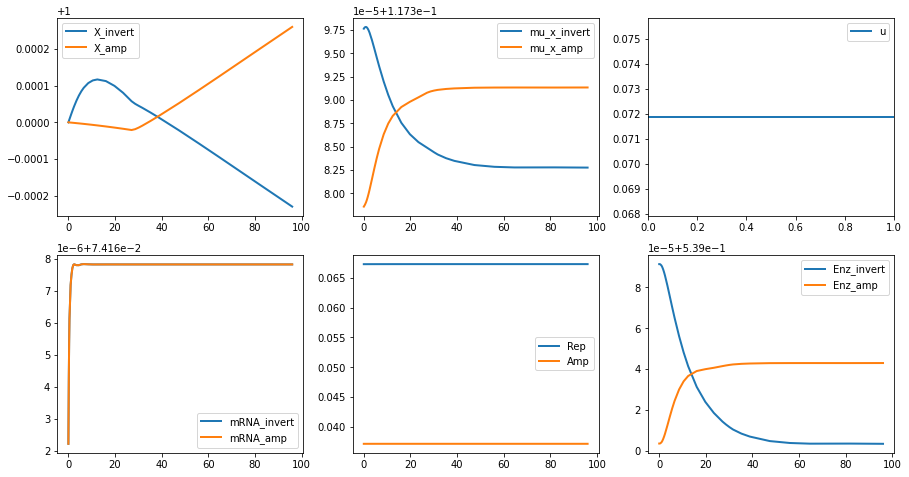

In [76]:
# AMP

t_final = 96

optogrowth_p =  kdegR, ktrans_Rep, ktrans_Amp, ktrans_scaled_PDC_amp, ktrans_scaled_PDC_invert, kdegP_Rep, kdegP_Amp, kdegPPDC, \
                mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0.07416222,  0.07416222,  0.06732167,  0.03712948,  0.53909129,
        0.53900371, 15.99890606, 1, 1]


tspan = [0, t_final*60]

# u_fun = lambda t: u_sine_amp * (((np.cos(2 * np.pi * t / (u_sine_period))+1)/2) ** u_sine_n) + u_sine_offset

def u_fun(t):
    sine_wave = ((np.cos(2 * np.pi * t / (u_sine_period))+1)/2)
    if favor_amp:
        output = (1 - sine_wave ** u_sine_n ) * 2 - 1
    else:
        output = (sine_wave ** u_sine_n) * 2 - 1
    return output * u_sine_amp + u_sine_offset
mRNA_fun = lambda t: u_to_mRNA_fun(u_fun(t))

od_sp = 2

period = 100 / 60  # 100 seconds
Imax = 1

setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp,mRNA_fun),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y



mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

print('mu Amp')
print(mu_x_amp[-1])
print(np.average(mu_x_amp[t_arr/60>80]))

print('mu Invert')
print(mu_x_invert[-1])
print(np.average(mu_x_invert[t_arr/60>80]))

plt.figure(facecolor='white', figsize=(15, 8))
ax = plt.subplot(2,3,1)
ax.plot(t_arr/60, X_invert, label='X_invert', linewidth = 2)
ax.plot(t_arr/60, X_amp, label='X_amp', linewidth = 2)
ax.legend()

ax = plt.subplot(2,3,2)
ax.plot(t_arr/60, mu_x_invert, label='mu_x_invert', linewidth = 2)
ax.plot(t_arr/60, mu_x_amp, label='mu_x_amp', linewidth = 2)
ax.legend()

ax = plt.subplot(2,3,3)
ax.plot(t_arr/60, u_fun(t_arr), label='u', linewidth = 2)
ax.set_xlim([0, 1])
ax.legend()

ax = plt.subplot(2,3,4)
ax.plot(t_arr/60, mRNA_invert, label='mRNA_invert', linewidth = 2)
ax.plot(t_arr/60, mRNA_amp, label='mRNA_amp', linewidth = 2)
ax.legend()

ax = plt.subplot(2,3,5)
ax.plot(t_arr/60, Rep, label='Rep', linewidth = 2)
ax.plot(t_arr/60, Amp, label='Amp', linewidth = 2)
ax.legend()

ax = plt.subplot(2,3,6)
ax.plot(t_arr/60, Enz_invert, label='Enz_invert', linewidth = 2)
ax.plot(t_arr/60, Enz_amp, label='Enz_amp', linewidth = 2)
ax.legend()